# nELISA × COVID-19 PBMC Proteomics Pipeline
**Author:** Giuliane Fuzetto Paschoal  
**Role Target:** Data Associate @ Nomic Bio  
**Goal:** Build end-to-end nELISA-style proteomics pipeline on Google Colab Jupyter Notebook showing:
- Loading Clinical COVID-19 Olink / nELISA datasets
- QC & normalization with edge-case detection
- COVID vs control effect-size estimation
- Concordance with PBMC immune stimulation assays
- Demo backend (“Cytokine Scientist Insight Simulation”)


# 1. Environment Set up

In [4]:
# 0. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1. Set paths to your dataset inside Drive
import os
base_path = "/content/drive/MyDrive/Proteomics/COVID19PtnDataset"

clinical_path = os.path.join(base_path, "COVID19PtnDataset_Clinical_Info.txt")
npx_path = os.path.join(base_path, "COVID19PtnDataset_NPX.txt")
desc_path = os.path.join(base_path, "variable_descriptions.xlsx")

print("Base folder:", base_path)
!ls "$base_path"

# 2. Load the data
import pandas as pd
import numpy as np

# The NPX data contains protein abundances
npx = pd.read_csv(npx_path, sep="\t")
# Clinical data: metadata for each sample
clinical = pd.read_csv(clinical_path, sep="\t")

# Variable descriptions (Excel)
desc = pd.read_excel(desc_path)

Mounted at /content/drive
Base folder: /content/drive/MyDrive/Proteomics/COVID19PtnDataset
COVID19_Proteo_Cleaned.csv	     outputs
COVID19PtnDataset_Clinical_Info.txt  outputs_case_study
COVID19PtnDataset_NPX.txt	     variable_descriptions.xlsx


# 1.1. Understanding COVID-19 Proteomics Dataset

In [5]:
print("\nNPX (protein-level) shape:", npx.shape)
print("Clinical shape:", clinical.shape)
print("Descriptions shape:", desc.shape)

# 3. Peek into each file
print("\n=== NPX columns ===")
print(npx.columns[:10].tolist())

print("\n=== Clinical columns ===")
print(clinical.columns.tolist())

print("\nSample of NPX:")
display(npx.head(3))

print("\nSample of Clinical Info:")
display(clinical.head(3))

print("\nVariable Descriptions:")
display(desc.head(3))


NPX (protein-level) shape: (1271808, 1)
Clinical shape: (384, 1)
Descriptions shape: (44, 2)

=== NPX columns ===
['SampleID;subject_id;Timepoint;Index;OlinkID;UniProt;Assay;MissingFreq;Panel;Panel_Lot_Nr;PlateID;QC_Warning;Assay_Warning;Normalization;LOD;NPX']

=== Clinical columns ===
['subject_id;COVID;Age_cat;BMI_cat;HEART;LUNG;KIDNEY;DIABETES;HTN;IMMUNO;Resp_Symp;Fever_Sympt;GI_Symp;D0_draw;D3_draw;D7_draw;DE_draw;Acuity_0;Acuity_3;Acuity_7;Acuity_28;Acuity_max;abs_neut_0_cat;abs_lymph_0_cat;abs_mono_0_cat;creat_0_cat;crp_0_cat;ddimer_0_cat;ldh_0_cat;Trop_72h;abs_neut_3_cat;abs_lymph_3_cat;abs_mono_3_cat;creat_3_cat;crp_3_cat;ddimer_3_cat;ldh_3_cat;abs_neut_7_cat;abs_lymph_7_cat;abs_mono_7_cat;creat_7_cat;crp_7_cat;ddimer_7_cat;ldh_7_cat']

Sample of NPX:


,SampleID;subject_id;Timepoint;Index;OlinkID;UniProt;Assay;MissingFreq;Panel;Panel_Lot_Nr;PlateID;QC_Warning;Assay_Warning;Normalization;LOD;NPX
0,1_D0;1;D0;56;OID21311;Q9BTE6;AARSD1;0;Oncology...
1,1_D0;1;D0;56;OID20921;Q96IU4;ABHD14B;0;Neurolo...
2,1_D0;1;D0;56;OID21280;P00519;ABL1;0.0013;Oncol...



Sample of Clinical Info:


,subject_id;COVID;Age_cat;BMI_cat;HEART;LUNG;KIDNEY;DIABETES;HTN;IMMUNO;Resp_Symp;Fever_Sympt;GI_Symp;D0_draw;D3_draw;D7_draw;DE_draw;Acuity_0;Acuity_3;Acuity_7;Acuity_28;Acuity_max;abs_neut_0_cat;abs_lymph_0_cat;abs_mono_0_cat;creat_0_cat;crp_0_cat;ddimer_0_cat;ldh_0_cat;Trop_72h;abs_neut_3_cat;abs_lymph_3_cat;abs_mono_3_cat;creat_3_cat;crp_3_cat;ddimer_3_cat;ldh_3_cat;abs_neut_7_cat;abs_lymph_7_cat;abs_mono_7_cat;creat_7_cat;crp_7_cat;ddimer_7_cat;ldh_7_cat
0,1;1;1;4;0;0;0;0;0;0;1;1;1;1;1;0;0;3;4;5;5;3;3;...
1,2;1;2;2;0;0;0;0;0;0;1;1;1;1;1;0;0;3;3;5;5;3;3;...
2,3;1;3;4;0;1;0;0;0;0;1;0;1;1;1;0;0;3;3;5;5;3;3;...



Variable Descriptions:


,Variable,Description
0,subject_id,Subject ID
1,COVID,COVID status (tested positive prior to enrollm...
2,Age cat,Age category 1 = 20-34 2 = 36-49 3 = ...


/tmp/ipython-input-2482598880.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  npx = pd.read_csv(npx_path, sep=';')


NPX shape: (1271808, 16)
Clinical shape: (384, 44)


,SampleID,subject_id,Timepoint,Index,OlinkID,UniProt,Assay,MissingFreq,Panel,Panel_Lot_Nr,PlateID,QC_Warning,Assay_Warning,Normalization,LOD,NPX
0,1_D0,1.0,D0,56,OID21311,Q9BTE6,AARSD1,0.0000,Oncology,B04404,20200772_Plate5,PASS,PASS,Intensity,-1.0810,1.9024
1,1_D0,1.0,D0,56,OID20921,Q96IU4,ABHD14B,0.0000,Neurology,B04406,20200772_Plate5,PASS,PASS,Intensity,-1.4574,-0.2625
2,1_D0,1.0,D0,56,OID21280,P00519,ABL1,0.0013,Oncology,B04404,20200772_Plate5,PASS,PASS,Intensity,-2.4697,0.2659


,subject_id,COVID,Age_cat,BMI_cat,HEART,LUNG,KIDNEY,DIABETES,HTN,IMMUNO,...,crp_3_cat,ddimer_3_cat,ldh_3_cat,abs_neut_7_cat,abs_lymph_7_cat,abs_mono_7_cat,creat_7_cat,crp_7_cat,ddimer_7_cat,ldh_7_cat
0,1,1,1,4,0,0,0,0,0,0,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,2,2,0,0,0,0,0,0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,3,4,0,1,0,0,0,0,...,3.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



NPX columns: ['SampleID', 'subject_id', 'Timepoint', 'Index', 'OlinkID', 'UniProt', 'Assay', 'MissingFreq', 'Panel', 'Panel_Lot_Nr', 'PlateID', 'QC_Warning', 'Assay_Warning', 'Normalization', 'LOD', 'NPX']
Clinical columns: ['subject_id', 'COVID', 'Age_cat', 'BMI_cat', 'HEART', 'LUNG', 'KIDNEY', 'DIABETES', 'HTN', 'IMMUNO', 'Resp_Symp', 'Fever_Sympt', 'GI_Symp', 'D0_draw', 'D3_draw', 'D7_draw', 'DE_draw', 'Acuity_0', 'Acuity_3', 'Acuity_7', 'Acuity_28', 'Acuity_max', 'abs_neut_0_cat', 'abs_lymph_0_cat', 'abs_mono_0_cat', 'creat_0_cat', 'crp_0_cat', 'ddimer_0_cat', 'ldh_0_cat', 'Trop_72h', 'abs_neut_3_cat', 'abs_lymph_3_cat', 'abs_mono_3_cat', 'creat_3_cat', 'crp_3_cat', 'ddimer_3_cat', 'ldh_3_cat', 'abs_neut_7_cat', 'abs_lymph_7_cat', 'abs_mono_7_cat', 'creat_7_cat', 'crp_7_cat', 'ddimer_7_cat', 'ldh_7_cat']

Protein matrix shape: (792, 1463)


Assay,AARSD1,ABHD14B,ABL1,ACAA1,ACAN,ACE2,ACOX1,ACP5,ACP6,ACTA2,...,WNT9A,WWP2,XCL1,XG,XPNPEP2,XRCC4,YES1,YTHDF3,ZBTB16,ZBTB17
SampleID,,,,,,,,,,,,,,,,,,,,,
100_D0,1.9122,0.9249,1.0991,0.9842,-1.2259,-1.1539,0.2385,-1.0061,-2.3361,-1.2647,...,-1.5532,0.2978,-1.4871,-1.6042,-1.2906,0.4083,3.3342,0.0931,2.2090,-0.1582
100_D3,2.5576,1.1387,-0.2497,0.9206,-1.5068,-0.8661,-0.0298,-0.6992,-2.0548,-0.9551,...,-2.0396,-0.0814,-1.1673,-1.3318,-1.3648,-0.1714,0.9431,0.3393,0.4538,0.2296
101_D0,0.7786,0.1376,-0.2933,-0.7252,-1.4606,-2.0980,-0.1697,-0.9879,-2.9434,-1.1106,...,-1.2260,-0.9639,-1.9973,-1.9256,-1.9994,1.2854,1.6891,-0.0515,1.1424,-0.2506



Merged dataset shape: (786, 1508)


,subject_id,COVID,Age_cat,BMI_cat,HEART,LUNG,KIDNEY,DIABETES,HTN,IMMUNO,...,WNT9A,WWP2,XCL1,XG,XPNPEP2,XRCC4,YES1,YTHDF3,ZBTB16,ZBTB17
0,1,1,1,4,0,0,0,0,0,0,...,-1.621900,0.103300,-2.1669,-1.456300,-1.5365,-0.373100,3.308100,0.608500,0.425900,-0.9462
1,1,1,1,4,0,0,0,0,0,0,...,-1.892000,-0.352800,-1.8459,-1.031700,-1.2799,0.066400,2.936200,0.030700,0.727100,-0.5865
2,1,1,1,4,0,0,0,0,0,0,...,-0.359931,-0.391954,-0.3991,-0.134708,-0.3836,-0.027023,0.049654,-0.285031,-0.016585,-0.3848



Initial protein column count: 1463
Filtered to 1463 numeric protein columns.
🧬 Proteins: 1463
🧍 Samples: 786
🩺 Metadata columns: 44

COVID status counts:
COVID
1    704
0     82
Name: count, dtype: int64

Missing values (top 10 proteins):


,0
ZBTB17,0.0
AARSD1,0.0
ABHD14B,0.0
ABL1,0.0
ACAA1,0.0
ACAN,0.0
ACE2,0.0
WASF1,0.0
WAS,0.0
WARS,0.0


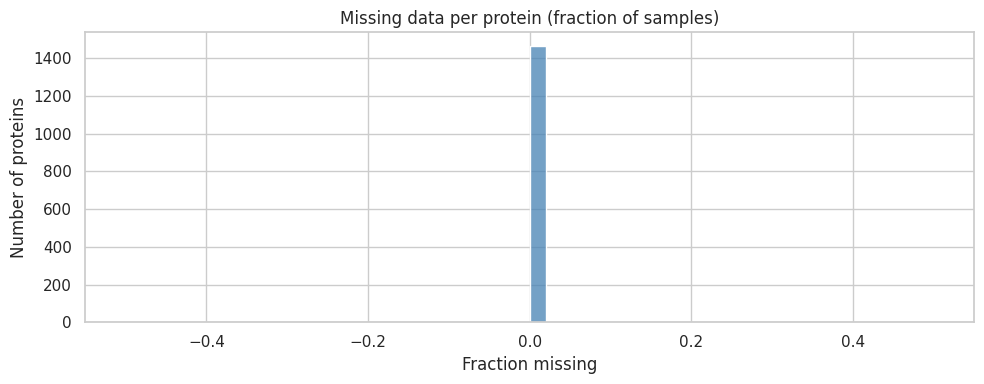

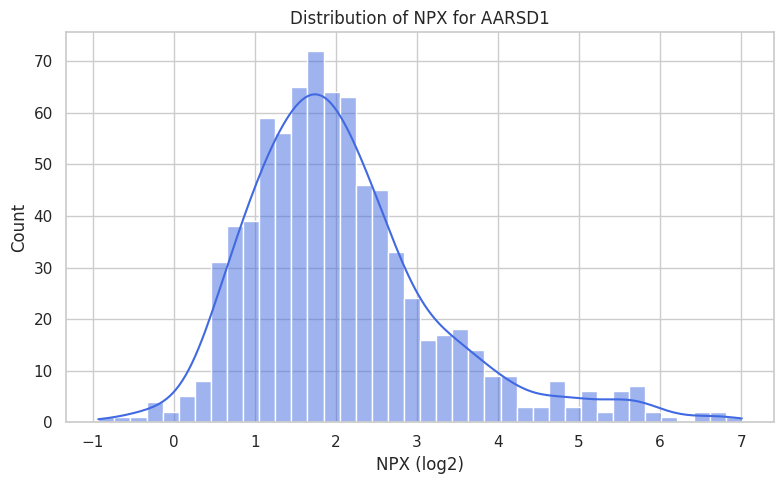

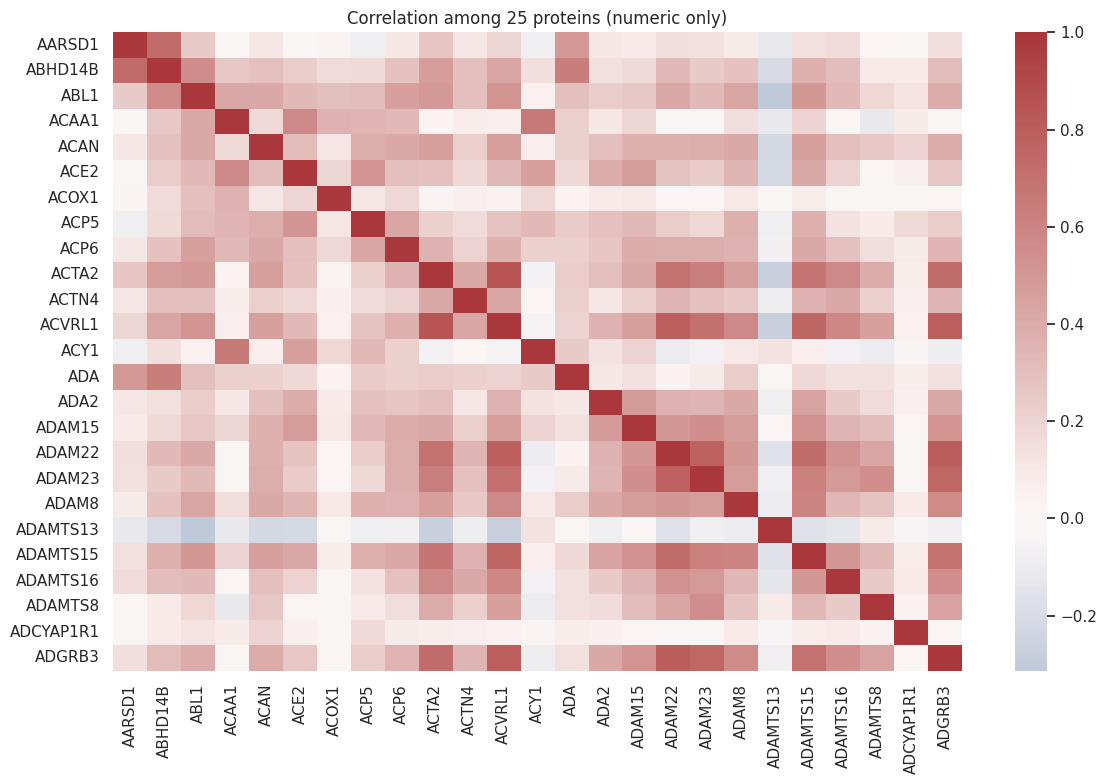

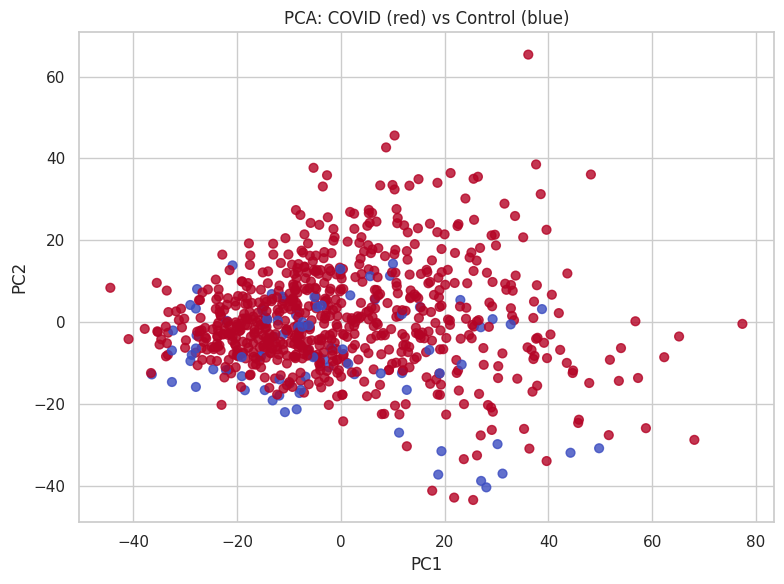


✅ Saved cleaned merged dataset to:
/content/drive/MyDrive/Proteomics/COVID19PtnDataset/COVID19_Proteo_Cleaned.csv


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make Colab render inline figures automatically
%matplotlib inline
sns.set(style="whitegrid", context="notebook", palette="muted")

# 4. Load with correct separator
npx = pd.read_csv(npx_path, sep=';')
clinical = pd.read_csv(clinical_path, sep=';')

print("NPX shape:", npx.shape)
print("Clinical shape:", clinical.shape)

display(npx.head(3))
display(clinical.head(3))

print("\nNPX columns:", npx.columns.tolist())
print("Clinical columns:", clinical.columns.tolist())

# 5. Pivot NPX: Sample × Protein matrix
prot_matrix = npx.pivot_table(index="SampleID", columns="Assay", values="NPX")
print("\nProtein matrix shape:", prot_matrix.shape)
display(prot_matrix.head(3))

# 6. Merge with clinical info
# Extract subject_id from SampleID (e.g., "1_D0" → 1)
prot_matrix = prot_matrix.reset_index()
prot_matrix["subject_id"] = prot_matrix["SampleID"].str.extract(r"(\d+)").astype(int)

merged = pd.merge(clinical, prot_matrix, on="subject_id", how="inner")
print("\nMerged dataset shape:", merged.shape)
display(merged.head(3))

# 7. Identify columns
meta_cols = clinical.columns.tolist()
protein_cols = [c for c in merged.columns if c not in meta_cols and c not in ["subject_id", "SampleID", "COVID"]]

print(f"\nInitial protein column count: {len(protein_cols)}")

# Keep only numeric protein columns
numeric_protein_cols = [
    c for c in protein_cols if pd.api.types.is_numeric_dtype(merged[c])
]
print(f"Filtered to {len(numeric_protein_cols)} numeric protein columns.")

# 8. Dataset overview
print(f"🧬 Proteins: {len(numeric_protein_cols)}")
print(f"🧍 Samples: {merged.shape[0]}")
print(f"🩺 Metadata columns: {len(meta_cols)}")
print("\nCOVID status counts:")
print(merged["COVID"].value_counts())

# 9. Missing data overview
missing_per_protein = merged[numeric_protein_cols].isna().mean().sort_values(ascending=False)
print("\nMissing values (top 10 proteins):")
display(missing_per_protein.head(10))

plt.figure(figsize=(10,4))
sns.histplot(missing_per_protein, bins=50, color="steelblue")
plt.title("Missing data per protein (fraction of samples)")
plt.xlabel("Fraction missing")
plt.ylabel("Number of proteins")
plt.tight_layout()
plt.show()

# 10. Distribution of an example protein
plt.figure(figsize=(8,5))
example_prot = numeric_protein_cols[0]
sns.histplot(merged[example_prot], bins=40, kde=True, color="royalblue")
plt.title(f"Distribution of NPX for {example_prot}")
plt.xlabel("NPX (log2)")
plt.tight_layout()
plt.show()

# 11. Correlation heatmap
subset_cols = numeric_protein_cols[:25]
corr = merged[subset_cols].corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("Correlation among 25 proteins (numeric only)")
plt.tight_layout()
plt.show()

# 12. PCA overview
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = merged[numeric_protein_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca[:,0], pca[:,1], c=merged["COVID"], cmap="coolwarm", s=40, alpha=0.8)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA: COVID (red) vs Control (blue)")
plt.tight_layout()
plt.show()

# 13. Save clean matrix for modeling
clean_path = os.path.join(base_path, "COVID19_Proteo_Cleaned.csv")
merged.to_csv(clean_path, index=False)
print(f"\n✅ Saved cleaned merged dataset to:\n{clean_path}")


# 1.2. Understanding nELISA PBMC Dataset

In [7]:
!git clone https://github.com/nplexbio/nELISA-PBMC.git /content/nELISA_PBMC

Cloning into '/content/nELISA_PBMC'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 114 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (114/114), 12.08 MiB | 8.26 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [8]:
import os
for f in os.listdir("/content/nELISA_PBMC"):
    print(f)
for f in os.listdir("/content/nELISA_PBMC/figure si.9"):
    print(f)


figure si.3
.git
figure 4
figure 2
figure si.7
figure si.4, 5
LICENSE (CC BY-NC 4.0).txt
figure 5
figure 3
LICENSE (Apache 2.0)
README.md
figure si.2
figure 1
figure si.9
data_df_olink_nelisa.csv
code_figure.h2h.ipynb


In [9]:
import pandas as pd

nelisa_path = "/content/nELISA_PBMC/figure si.9/data_df_olink_nelisa.csv"

# Try reading automatically
df = pd.read_csv(nelisa_path)

print("File loaded successfully")
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist()[:50])  # show first 50 names

print("\nFirst 5 rows:")
display(df.head(5))


File loaded successfully
Shape: (7656, 39)

Columns:
['Unnamed: 0', 'sample', 'row', 'column', 'WellID', 'donor', 'stimulus', 'LPS (ng/mL)', 'ConA (ug/mL)', 'PolyIC (ug/mL)', 'PMA (ng/mL)', 'ionomicyn (ng/mL)', 'nELISA ID', 'nELISA SNR', 'UniProt', 'SampleID', 'SampleType', 'PlateID', 'DataAnalysisRefID', 'OlinkID', 'Assay', 'AssayType', 'Panel', 'Block', 'Count', 'ExtNPX', 'NPX', 'Normalization', 'PCNormalizedNPX', 'AssayQC', 'SampleQC', 'ExploreVersion', 'IntraCV', 'InterCV', 'SampleBlockQCWarn', 'SampleBlockQCFail', 'BlockQCFail', 'AssayQCWarn', 'NCLOD']

First 5 rows:


,Unnamed: 0,sample,row,column,WellID,donor,stimulus,LPS (ng/mL),ConA (ug/mL),PolyIC (ug/mL),...,AssayQC,SampleQC,ExploreVersion,IntraCV,InterCV,SampleBlockQCWarn,SampleBlockQCFail,BlockQCFail,AssayQCWarn,NCLOD
0,968,1,A,1,A1,D1,unstimulated,0.0,0.0,0.0,...,PASS,PASS,7.2.1,4.729571,NaN,1.0,1.0,1.0,1.0,0.2
1,969,2,A,2,A2,D1,ConA,0.0,0.5,0.0,...,PASS,PASS,7.2.1,4.729571,NaN,1.0,1.0,1.0,1.0,0.2
2,970,3,A,3,A3,D1,ConA,0.0,2.5,0.0,...,PASS,PASS,7.2.1,4.729571,NaN,1.0,1.0,1.0,1.0,0.2
3,971,4,A,4,A4,D1,ConA,0.0,12.5,0.0,...,PASS,PASS,7.2.1,4.729571,NaN,1.0,1.0,1.0,1.0,0.2
4,972,5,A,5,A5,D1,ConA,0.0,25.0,0.0,...,PASS,PASS,7.2.1,4.729571,NaN,1.0,1.0,1.0,1.0,0.2


# 1.3. QC, Missingness & Normalization

After QC filtering: (6375, 39)
Wide shape: (88, 88)


Assay,SampleID,donor,stimulus,ANGPT1,ANGPTL4,BSG,CCL11,CCL13,CCL17,CCL20,...,TNF,TNFRSF13B,TNFRSF14,TNFRSF4,TNFSF10,TNFSF12,TNFSF13,TREM2,VEGFA,VEGFD
0,A1,D1,unstimulated,-0.475453,-9.768636,-4.520772,-9.653792,-10.493444,-4.511243,-7.493109,...,-0.797395,-2.853007,-1.168010,-4.464108,-7.326033,-6.557382,-5.246552,-6.392051,-5.333402,-9.622233
1,A10,D1,LPS,-0.422541,-8.229119,-4.894022,-10.021769,-7.469103,-2.173356,-3.321425,...,NaN,-2.539120,-1.130408,-4.215928,-6.623619,-9.577435,-5.075343,-8.802034,-5.907829,-10.253244
2,A11,D1,LPS,-0.310250,-9.946458,-5.120342,-8.083438,-6.115735,-1.935842,-3.240325,...,NaN,-2.294374,-1.073553,-4.139993,-6.229609,-6.276533,-4.896996,-8.729793,-6.084975,-10.859234


Detected proteins: 85


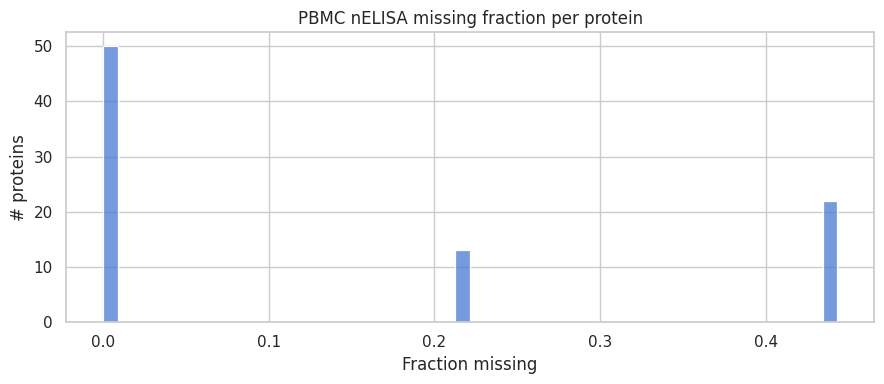

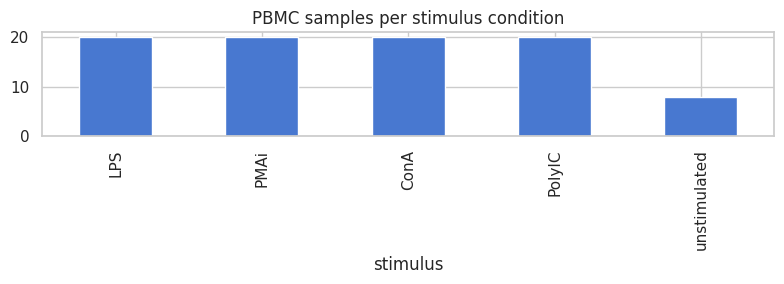

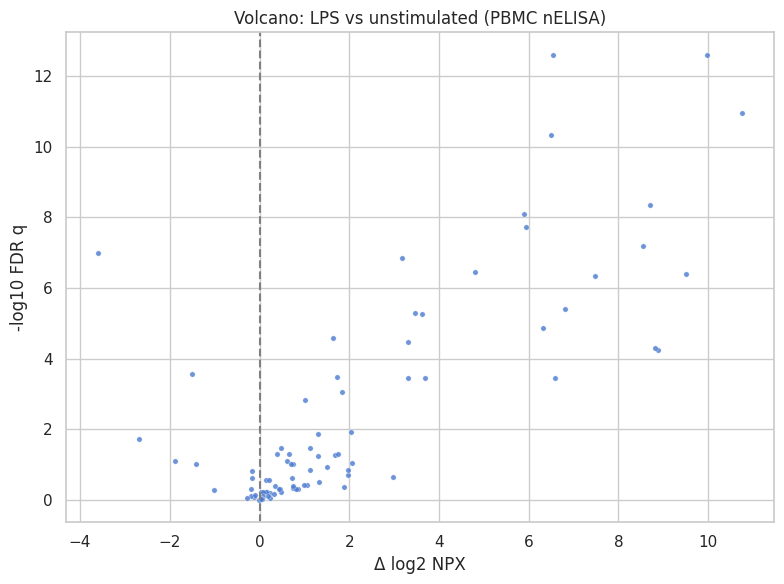

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


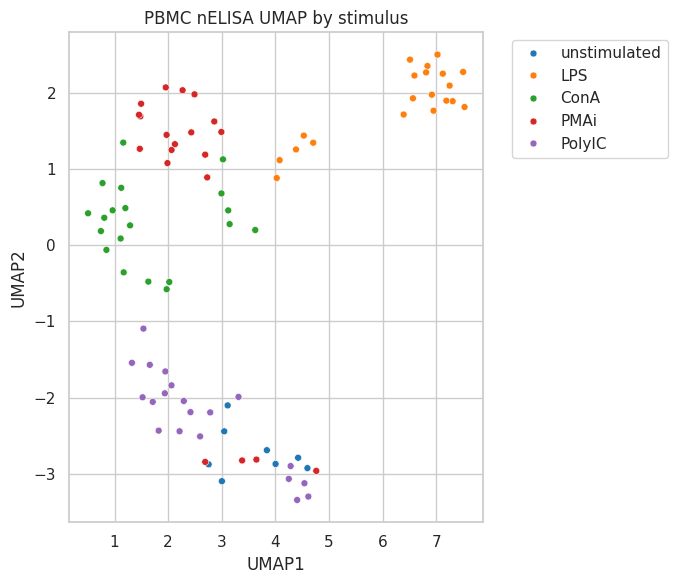

In [10]:
# =============================================================
# QC the nELISA PBMC dataset
# =============================================================
from IPython.display import display
nelisa = df.copy()
# Keep only fully QC-passed rows
nelisa = nelisa[(nelisa["AssayQC"] == "PASS") & (nelisa["SampleQC"] == "PASS")]
print("After QC filtering:", nelisa.shape)

# Pivot from long → wide (SampleID × Protein)
pbmc_wide = nelisa.pivot_table(index=["SampleID", "donor", "stimulus"],
                               columns="Assay",
                               values="NPX",
                               aggfunc="mean")

pbmc_wide = pbmc_wide.reset_index()
print("Wide shape:", pbmc_wide.shape)

# Examine a few samples
display(pbmc_wide.head(3))

# Get list of proteins
pbmc_prots = [c for c in pbmc_wide.columns if c not in ["SampleID", "donor", "stimulus"]]
print("Detected proteins:", len(pbmc_prots))

# -------------------------------------------------------------
# Exploratory plots
# -------------------------------------------------------------
import seaborn as sns, matplotlib.pyplot as plt

# 1. Missingness
miss = pbmc_wide[pbmc_prots].isna().mean()
plt.figure(figsize=(9,4))
sns.histplot(miss, bins=50)
plt.title("PBMC nELISA missing fraction per protein")
plt.xlabel("Fraction missing"); plt.ylabel("# proteins")
plt.tight_layout(); plt.show()

# 2. Stimulus counts
plt.figure(figsize=(8,3))
pbmc_wide["stimulus"].value_counts().plot(kind="bar")
plt.title("PBMC samples per stimulus condition")
plt.tight_layout(); plt.show()

# 3. Volcano-like comparison: e.g. LPS vs unstimulated
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

stim_A = "LPS"
stim_B = "unstimulated"

dfA = pbmc_wide[pbmc_wide["stimulus"] == stim_A]
dfB = pbmc_wide[pbmc_wide["stimulus"] == stim_B]

pvals, deltas = [], []
for p in pbmc_prots:
    t, pval = stats.ttest_ind(dfA[p], dfB[p], equal_var=False, nan_policy="omit")
    pvals.append(pval if np.isfinite(pval) else 1.0)
    deltas.append(dfA[p].mean() - dfB[p].mean())

res = pd.DataFrame({"protein": pbmc_prots, "delta_log2": deltas, "pval": pvals})
res["qval"] = multipletests(res["pval"], method="fdr_bh")[1]
res["-log10q"] = -np.log10(np.clip(res["qval"], 1e-300, 1))

plt.figure(figsize=(8,6))
sns.scatterplot(data=res, x="delta_log2", y="-log10q", s=15, alpha=0.8)
plt.axvline(0, ls="--", c="gray")
plt.title(f"Volcano: {stim_A} vs {stim_B} (PBMC nELISA)")
plt.xlabel("Δ log2 NPX")
plt.ylabel("-log10 FDR q")
plt.tight_layout(); plt.show()

# 4. UMAP visualization
from sklearn.preprocessing import StandardScaler
import umap

X = pbmc_wide[pbmc_prots].fillna(pbmc_wide[pbmc_prots].mean())
X_scaled = StandardScaler().fit_transform(X)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.15, random_state=42)
U = reducer.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(x=U[:,0], y=U[:,1], hue=pbmc_wide["stimulus"], palette="tab10", s=25)
plt.title("PBMC nELISA UMAP by stimulus")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout(); plt.show()


# 2. COVID-19 Analysis

Proteins: 1463


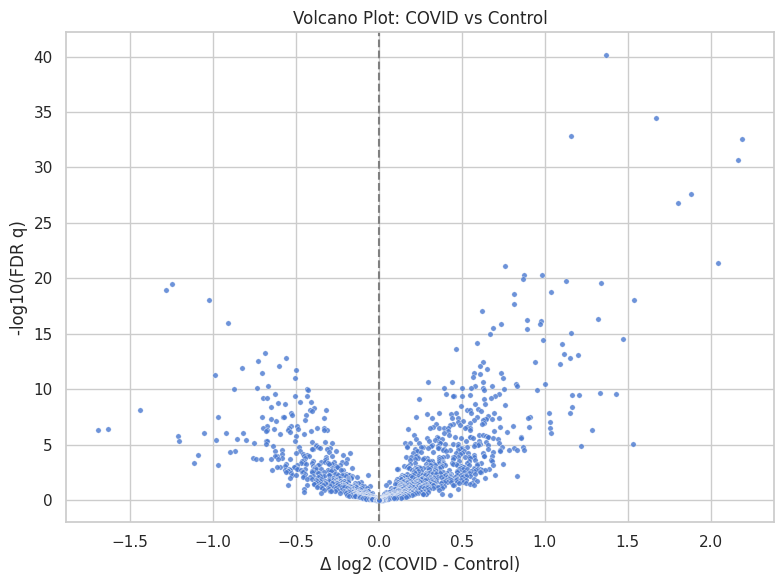

,protein,delta_log2,pval,qval,-log10(q)
0,IFNL1,1.369718,4.603029e-44,6.734231e-41,40.171712
1,C4BPB,1.670744,5.287823e-38,3.868043e-35,34.412509
2,GOLM2,1.158005,3.126074e-36,1.524482e-33,32.816878
3,CCL7,2.187867,7.809334e-36,2.856264e-33,32.544202
4,DDX58,2.166070,6.792140e-34,1.987380e-31,30.701719
5,BST2,1.880400,9.733898e-31,2.373449e-28,27.624620
6,NADK,1.802532,8.191878e-30,1.712103e-27,26.766470
7,CXCL10,2.045640,2.463314e-24,4.504786e-22,21.346326
8,TCN2,0.761523,4.832187e-24,7.854988e-22,21.104854
9,TPP1,0.984217,3.363007e-23,4.895421e-21,20.310210


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


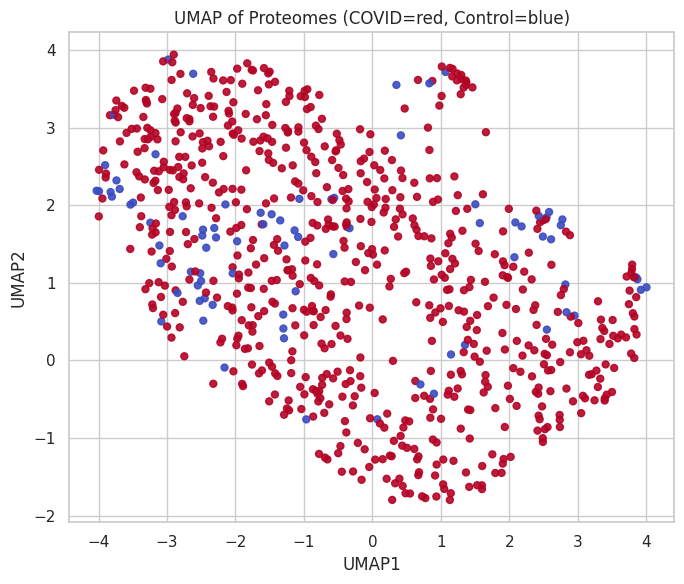

5-fold LogReg AUC: 0.989 ± 0.005
AE epoch 30/150  | loss=0.5163
AE epoch 60/150  | loss=0.4346
AE epoch 90/150  | loss=0.4074
AE epoch 120/150  | loss=0.3928
AE epoch 150/150  | loss=0.3804


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


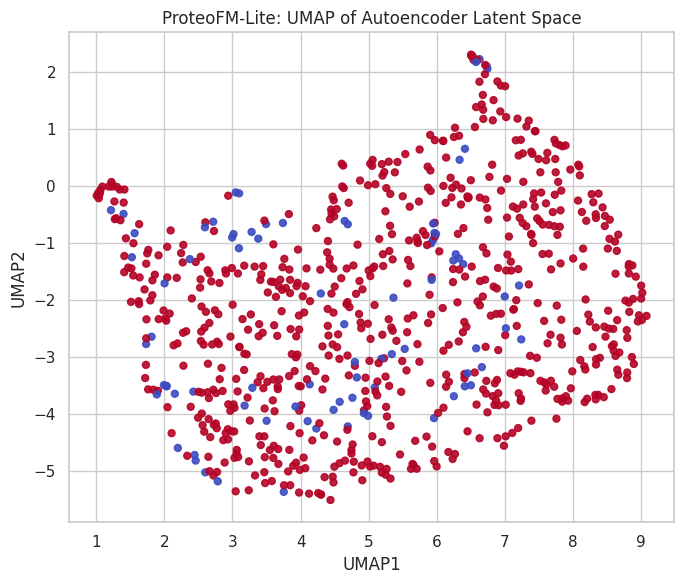


COVID19 Proteomics Summary
Samples: 786, Proteins: 1463
Class balance: 704 COVID / 82 controls
LogReg AUC: 0.989 ± 0.005
Top 5 differential proteins:
protein  delta_log2         qval
  IFNL1    1.369718 6.734231e-41
  C4BPB    1.670744 3.868043e-35
  GOLM2    1.158005 1.524482e-33
   CCL7    2.187867 2.856264e-33
  DDX58    2.166070 1.987380e-31


 Results saved to: /content/drive/MyDrive/Proteomics/COVID19PtnDataset/outputs


In [11]:
# ==================================================================
# Proteomics Analysis — Volcano, UMAP, Autoencoder on COVID-19 Data
# ==================================================================

import numpy as np, pandas as pd, os, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy import stats
from statsmodels.stats.multitest import multipletests
import umap
import torch
from torch import nn

%matplotlib inline
sns.set(style="whitegrid", context="notebook", palette="muted")

# 1. Prepare data
print("Proteins:", len(numeric_protein_cols))
X = merged[numeric_protein_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
y = merged["COVID"].astype(int).values

# 2. Differential analysis (t-test + FDR)
case = X[y==1]; ctrl = X[y==0]
pvals, log2fc = [], []
for col in numeric_protein_cols:
    t, p = stats.ttest_ind(case[col], ctrl[col], equal_var=False, nan_policy='omit')
    pvals.append(p if np.isfinite(p) else 1.0)
    log2fc.append(case[col].mean() - ctrl[col].mean())

res = pd.DataFrame({
    "protein": numeric_protein_cols,
    "delta_log2": log2fc,
    "pval": pvals
})
res["qval"] = multipletests(res["pval"].values, method="fdr_bh")[1]
res["-log10(q)"] = -np.log10(np.clip(res["qval"].values, 1e-300, 1))
res = res.sort_values("qval").reset_index(drop=True)

# 3. Volcano plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=res, x="delta_log2", y="-log10(q)", s=15, alpha=0.8)
plt.axvline(0, ls="--", c="gray")
plt.xlabel("Δ log2 (COVID - Control)")
plt.ylabel("-log10(FDR q)")
plt.title("Volcano Plot: COVID vs Control")
plt.tight_layout()
plt.show()

display(res.head(10))

# 4. UMAP of samples
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=20, min_dist=0.15, random_state=42)
U = reducer.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(U[:,0], U[:,1], c=y, cmap="coolwarm", s=25, alpha=0.9)
plt.title("UMAP of Proteomes (COVID=red, Control=blue)")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

# 5. Logistic Regression
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []
for tr, te in skf.split(X_scaled, y):
    clf = LogisticRegression(max_iter=2000, class_weight="balanced")
    clf.fit(X_scaled[tr], y[tr])
    aucs.append(roc_auc_score(y[te], clf.predict_proba(X_scaled[te])[:,1]))
print(f"5-fold LogReg AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# 6. Mini Autoencoder
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
input_dim = X_tensor.shape[1]; latent_dim = 8

class AE(nn.Module):
    def __init__(self, d_in, d_lat):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(),
            nn.Linear(256, d_lat)
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_lat, 256), nn.ReLU(),
            nn.Linear(256, d_in)
        )
    def forward(self, x):
        z = self.encoder(x); xr = self.decoder(z)
        return xr, z

ae = AE(input_dim, latent_dim)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

for epoch in range(150):
    opt.zero_grad()
    xr, z = ae(X_tensor)
    loss = loss_fn(xr, X_tensor)
    loss.backward(); opt.step()
    if (epoch+1) % 30 == 0:
        print(f"AE epoch {epoch+1}/150  | loss={loss.item():.4f}")

# 7. Visualize Autoencoder latent space
ae.eval()
with torch.no_grad():
    Z = ae.encoder(X_tensor).numpy()
U_z = umap.UMAP(n_neighbors=20, min_dist=0.2, random_state=42).fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(U_z[:,0], U_z[:,1], c=y, cmap="coolwarm", s=25, alpha=0.9)
plt.title("ProteoFM-Lite: UMAP of Autoencoder Latent Space")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

# 8. Save key outputs
out_dir = os.path.join(base_path, "outputs")
os.makedirs(out_dir, exist_ok=True)

res.to_csv(os.path.join(out_dir, "differential_proteins.csv"), index=False)
pd.DataFrame(U, columns=["UMAP1","UMAP2"]).assign(COVID=y).to_csv(os.path.join(out_dir, "umap_coords.csv"), index=False)
pd.DataFrame(Z).to_csv(os.path.join(out_dir, "autoencoder_latents.csv"), index=False)

summary = f"""
COVID19 Proteomics Summary
Samples: {X.shape[0]}, Proteins: {X.shape[1]}
Class balance: {int(y.sum())} COVID / {int((1-y).sum())} controls
LogReg AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}
Top 5 differential proteins:
{res.head(5)[['protein','delta_log2','qval']].to_string(index=False)}
"""
print(summary)

with open(os.path.join(out_dir, "ProteoFM_summary.txt"), "w") as f:
    f.write(summary)
print("\n Results saved to:", out_dir)


# 3. Concordance with PBMC Stimulation

Common proteins between COVID and PBMC: 85
Spearman rho (effect sizes): 0.265 | Pearson r: 0.197


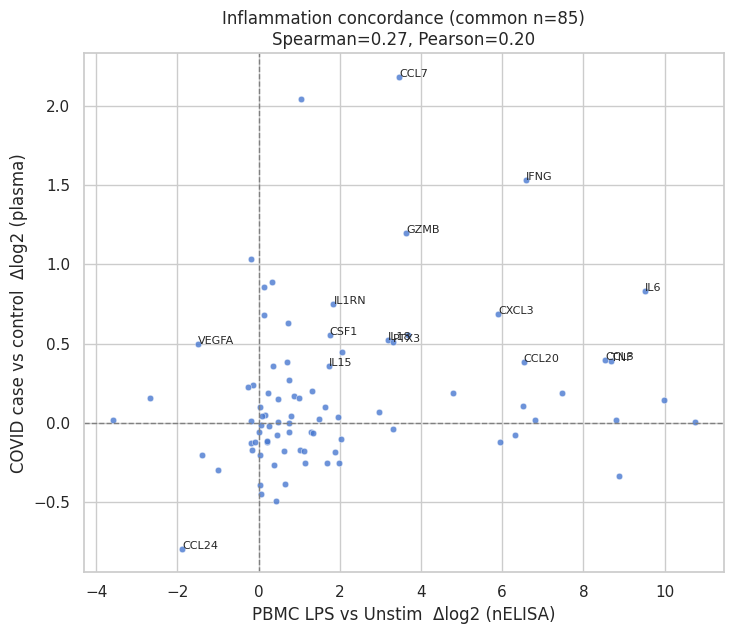

Saved: /content/drive/MyDrive/Proteomics/COVID19PtnDataset/outputs_case_study/covid_pbmc_concordance_scatter.png

Top concordant pro-inflammatory candidates (both contexts up, FDR<0.05):


,protein,covid_delta,covid_q,pbmc_delta,pbmc_q
14,CCL7,2.187867,6.637934e-34,3.462525,5.084050e-06
34,GZMB,1.197994,4.418938e-14,3.631862,5.291790e-06
17,CSF1,0.553313,1.530933e-08,1.746443,4.825235e-02
48,IL18,0.523909,6.228872e-06,3.176427,1.446022e-07
35,IFNG,1.533640,1.286513e-05,6.586224,3.499003e-04
42,IL15,0.358145,2.565279e-05,1.729857,3.229953e-04
75,TNF,0.390340,2.783761e-05,8.691545,4.468753e-09
53,IL1RN,0.749201,6.875716e-04,1.842924,9.000749e-04
24,CXCL3,0.688004,7.593355e-04,5.903476,8.250999e-09
72,PTX3,0.512183,1.107760e-03,3.299958,3.394619e-05



Top opposite-direction proteins (context-specific regulation):


,protein,covid_delta,covid_q,pbmc_delta,pbmc_q
83,VEGFA,0.496437,2.670907e-05,-1.506441,2.658584e-04
37,IL10RB,-0.269556,2.603651e-03,0.388617,4.825235e-02
78,TNFRSF4,-0.390364,3.384119e-03,0.653602,4.825235e-02
18,CSF3,-0.341024,1.087806e-01,8.876795,5.534780e-05
29,FASLG,-0.174195,6.356959e-02,1.007952,1.455005e-03
66,MMP10,-0.125640,3.948314e-01,5.949040,1.826671e-08
21,CXCL12,0.153872,6.356959e-02,-2.679499,1.822715e-02
68,PDGFB,1.032621,1.166109e-07,-0.186404,5.010833e-01
5,CCL17,-0.258052,1.087806e-01,1.674553,5.178934e-02
58,IL4,-0.177582,1.651105e-01,1.128351,3.341735e-02


In [12]:
# =============================================================
# 🔗 COVID-19 x PBMC nELISA: inflammation study
#     We have:
#       - merged (COVID) dataframe with "COVID" column and NPX protein columns
#       - protein_cols list for COVID NPX columns (numeric)
#       - pbmc_wide (PBMC) with columns ["SampleID","donor","stimulus", <proteins>]
#       - pbmc_prots list of PBMC protein columns
#       - outputs_dir defined (string path)
# =============================================================
import os, numpy as np, pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Find shared protein names (case-sensitive intersection)
covid_prots = [c for c in merged.columns if c in protein_cols]  # numeric NPX columns
common = sorted(list(set(covid_prots).intersection(set(pbmc_prots))))
print(f"Common proteins between COVID and PBMC: {len(common)}")
if len(common) < 10:
    print("⚠️ Few overlaps — continue, but interpretation will be limited.")

# 2. COVID effect size: case vs control (Δ log2 NPX) + q-values
covA = merged[merged["COVID"]==1][common]
covB = merged[merged["COVID"]==0][common]

cov_t, cov_p = [], []
cov_delta = []
for p in common:
    a = covA[p].astype(float)
    b = covB[p].astype(float)
    t, pval = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
    cov_t.append(t)
    cov_p.append(pval if np.isfinite(pval) else 1.0)
    cov_delta.append(a.mean() - b.mean())

cov_df = pd.DataFrame({"protein": common, "covid_delta": cov_delta, "covid_p": cov_p})
cov_df["covid_q"] = multipletests(cov_df["covid_p"], method="fdr_bh")[1]
cov_df["covid_-log10q"] = -np.log10(np.clip(cov_df["covid_q"], 1e-300, 1))

# 3. PBMC effect size: LPS vs Unstim (Δ log2 NPX) + q-values
stim_A, stim_B = "LPS", "unstimulated"
pbA = pbmc_wide[pbmc_wide["stimulus"]==stim_A][common]
pbB = pbmc_wide[pbmc_wide["stimulus"]==stim_B][common]

pb_p, pb_delta = [], []
for p in common:
    t, pval = stats.ttest_ind(pbA[p], pbB[p], equal_var=False, nan_policy="omit")
    pb_p.append(pval if np.isfinite(pval) else 1.0)
    pb_delta.append(pbA[p].mean() - pbB[p].mean())

pb_df = pd.DataFrame({"protein": common, "pbmc_delta": pb_delta, "pbmc_p": pb_p})
pb_df["pbmc_q"] = multipletests(pb_df["pbmc_p"], method="fdr_bh")[1]
pb_df["pbmc_-log10q"] = -np.log10(np.clip(pb_df["pbmc_q"], 1e-300, 1))

# 4. Join and compute concordance
fx = cov_df.merge(pb_df, on="protein", how="inner")
rho_s = fx[["covid_delta","pbmc_delta"]].corr(method="spearman").iloc[0,1]
rho_p = fx[["covid_delta","pbmc_delta"]].corr(method="pearson").iloc[0,1]
print(f"Spearman rho (effect sizes): {rho_s:.3f} | Pearson r: {rho_p:.3f}")

# 5. Scatter with labels for top inflammatory hits
# Rank by significance in BOTH contexts (sum of -log10q ranks)
fx["rank_cov"] = fx["covid_-log10q"].rank(ascending=False)
fx["rank_pb"]  = fx["pbmc_-log10q"].rank(ascending=False)
fx["joint_rank"] = fx["rank_cov"] + fx["rank_pb"]

topN = 15
lab = fx.sort_values("joint_rank").head(topN)["protein"].tolist()

plt.figure(figsize=(7.5,6.5))
sns.scatterplot(data=fx, x="pbmc_delta", y="covid_delta", s=22, alpha=0.8)
plt.axhline(0, ls="--", c="gray", lw=1); plt.axvline(0, ls="--", c="gray", lw=1)
for _, row in fx[fx["protein"].isin(lab)].iterrows():
    plt.text(row["pbmc_delta"], row["covid_delta"], row["protein"], fontsize=8)

plt.xlabel("PBMC LPS vs Unstim  Δlog2 (nELISA)")
plt.ylabel("COVID case vs control  Δlog2 (plasma)")
plt.title(f"Inflammation concordance (common n={len(common)})\n"
          f"Spearman={rho_s:.2f}, Pearson={rho_p:.2f}")
plt.tight_layout()

# Define outputs_dir here
outputs_dir = "/content/drive/MyDrive/Proteomics/COVID19PtnDataset/outputs_case_study"
os.makedirs(outputs_dir, exist_ok=True)

scatter_path = os.path.join(outputs_dir, "covid_pbmc_concordance_scatter.png")
plt.savefig(scatter_path, dpi=160)
plt.show()
print("Saved:", scatter_path)

# 6. Print top concordant up-regulated candidates (both deltas >0, both q<0.05)
hit_up = fx[(fx["covid_delta"]>0) & (fx["covid_q"]<0.05) &
            (fx["pbmc_delta"]>0) & (fx["pbmc_q"]<0.05)].copy()
hit_up = hit_up.sort_values(["covid_-log10q","pbmc_-log10q"], ascending=False).head(25)
print("\nTop concordant pro-inflammatory candidates (both contexts up, FDR<0.05):")
display(hit_up[["protein","covid_delta","covid_q","pbmc_delta","pbmc_q"]])

# 7. And top discordant (directions opposite) — interesting biology to discuss
hit_opp = fx[((fx["covid_delta"]>0) & (fx["pbmc_delta"]<0)) |
             ((fx["covid_delta"]<0) & (fx["pbmc_delta"]>0))].copy()
hit_opp = hit_opp.sort_values("joint_rank").head(20)
print("\nTop opposite-direction proteins (context-specific regulation):")
display(hit_opp[["protein","covid_delta","covid_q","pbmc_delta","pbmc_q"]])

# Save table snapshots
fx.sort_values("joint_rank").to_csv(os.path.join(outputs_dir,"covid_pbmc_effectsize_table.csv"), index=False)
hit_up.to_csv(os.path.join(outputs_dir,"covid_pbmc_concordant_hits.csv"), index=False)
hit_opp.to_csv(os.path.join(outputs_dir,"covid_pbmc_opposite_hits.csv"), index=False)





,stimulus,n_common,spearman,pearson
0,LPS,85,0.265155,0.196841
1,PolyIC,85,0.246140,0.522589
2,PMAi,85,0.190678,0.269728
3,ConA,85,0.097323,0.217990


Best-matching PBMC condition vs COVID: LPS


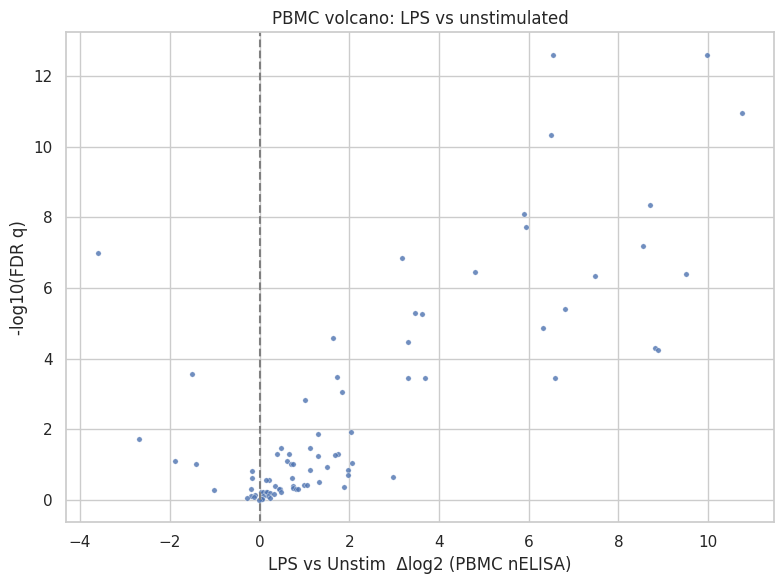

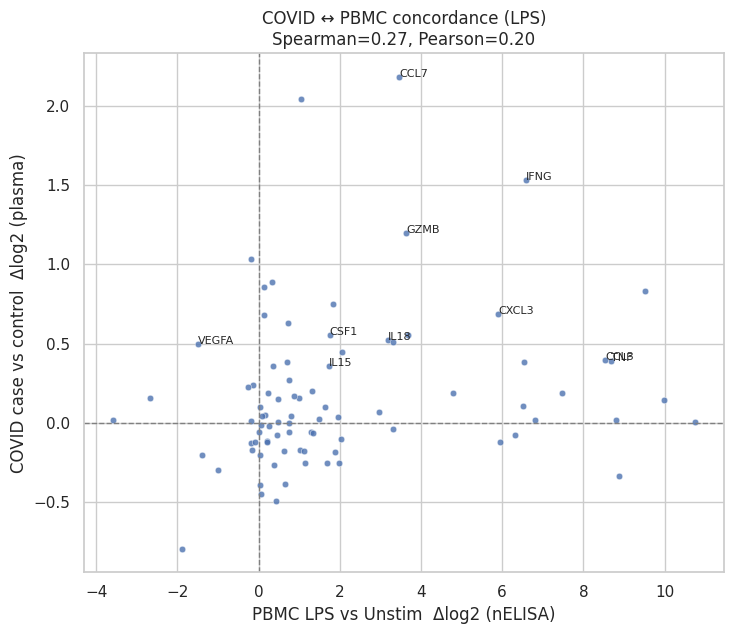

In [13]:
# =============================================================
# Pick the PBMC stimulus that best matches the COVID signature
# =============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
sns.set(style="whitegrid", context="notebook")

# Recompute COVID deltas on the fly for safety (case minus control)
common_all = sorted(list(set(protein_cols).intersection(set(pbmc_prots))))
covA = merged.loc[merged["COVID"]==1, common_all].astype(float)
covB = merged.loc[merged["COVID"]==0, common_all].astype(float)
cov_p, cov_delta = [], []
for p in common_all:
    t, pval = stats.ttest_ind(covA[p], covB[p], equal_var=False, nan_policy="omit")
    cov_p.append(pval if np.isfinite(pval) else 1.0)
    cov_delta.append(covA[p].mean() - covB[p].mean())
cov_tbl = pd.DataFrame({"protein": common_all, "covid_delta": cov_delta, "covid_p": cov_p})
cov_tbl["covid_q"] = multipletests(cov_tbl["covid_p"], method="fdr_bh")[1]

# 1) Loop over PBMC stimuli vs unstimulated
stimuli = sorted([s for s in pbmc_wide["stimulus"].unique() if str(s).lower() != "unstimulated"])
results = []
per_stim_tables = {}

for stim in stimuli:
    pbA = pbmc_wide.loc[pbmc_wide["stimulus"]==stim, common_all]
    pbB = pbmc_wide.loc[pbmc_wide["stimulus"]=="unstimulated", common_all]
    pb_p, pb_delta = [], []
    for p in common_all:
        t, pval = stats.ttest_ind(pbA[p], pbB[p], equal_var=False, nan_policy="omit")
        pb_p.append(pval if np.isfinite(pval) else 1.0)
        pb_delta.append(pbA[p].mean() - pbB[p].mean())
    pb_tbl = pd.DataFrame({"protein": common_all, "pbmc_delta": pb_delta, "pbmc_p": pb_p})
    pb_tbl["pbmc_q"] = multipletests(pb_tbl["pbmc_p"], method="fdr_bh")[1]
    fx = cov_tbl.merge(pb_tbl, on="protein", how="inner")
    rho_s = fx[["covid_delta","pbmc_delta"]].corr(method="spearman").iloc[0,1]
    rho_p = fx[["covid_delta","pbmc_delta"]].corr(method="pearson").iloc[0,1]
    results.append({"stimulus": stim, "n_common": len(fx), "spearman": rho_s, "pearson": rho_p})
    per_stim_tables[stim] = fx.sort_values("pbmc_q")

res_df = pd.DataFrame(results).sort_values("spearman", ascending=False).reset_index(drop=True)
display(res_df)

best_stim = res_df.iloc[0]["stimulus"]
print(f"Best-matching PBMC condition vs COVID: {best_stim}")

fx_best = per_stim_tables[best_stim].copy()

# 2) Volcano for the best stimulus
plt.figure(figsize=(8,6))
fx_best["-log10q_pb"] = -np.log10(np.clip(fx_best["pbmc_q"], 1e-300, 1))
sns.scatterplot(x=fx_best["pbmc_delta"], y=fx_best["-log10q_pb"], s=15, alpha=0.8)
plt.axvline(0, ls="--", c="gray")
plt.xlabel(f"{best_stim} vs Unstim  Δlog2 (PBMC nELISA)")
plt.ylabel("-log10(FDR q)")
plt.title(f"PBMC volcano: {best_stim} vs unstimulated")
plt.tight_layout(); plt.show()

# 3) Concordance scatter with top 10 shared cytokines labeled
# Rank by combined significance
fx_best["cov_score"] = -np.log10(np.clip(fx_best["covid_q"], 1e-300, 1))
fx_best["pb_score"]  = -np.log10(np.clip(fx_best["pbmc_q"],  1e-300, 1))
fx_best["joint_rank"] = fx_best["cov_score"].rank(ascending=False) + fx_best["pb_score"].rank(ascending=False)
top10 = fx_best.sort_values("joint_rank").head(10)

rho_s = fx_best[["covid_delta","pbmc_delta"]].corr(method="spearman").iloc[0,1]
rho_p = fx_best[["covid_delta","pbmc_delta"]].corr(method="pearson").iloc[0,1]

plt.figure(figsize=(7.5,6.5))
sns.scatterplot(data=fx_best, x="pbmc_delta", y="covid_delta", s=22, alpha=0.8)
plt.axhline(0, ls="--", c="gray", lw=1); plt.axvline(0, ls="--", c="gray", lw=1)
for _, r in top10.iterrows():
    plt.text(r["pbmc_delta"], r["covid_delta"], r["protein"], fontsize=8)
plt.xlabel(f"PBMC {best_stim} vs Unstim  Δlog2 (nELISA)")
plt.ylabel("COVID case vs control  Δlog2 (plasma)")
plt.title(f"COVID ↔ PBMC concordance ({best_stim})\nSpearman={rho_s:.2f}, Pearson={rho_p:.2f}")
plt.tight_layout(); plt.show()


# 4. Cytokine Insight Engine (Demo Backend)

In [14]:
# ============================================
# Cytokine Insight Engine (Demo Backend)
# ============================================

from typing import List, Dict, Callable, Any
import numpy as np
import pandas as pd

# 1. Routing Table + Decorator
ROUTES: Dict[str, Callable] = {}

def route(path: str):
    """Decorator to register service functions as API endpoints."""
    def wrapper(func: Callable):
        ROUTES[path] = func
        return func
    return wrapper


# 2. Load Example COVID Cytokine Effect Sizes (top 5 for demo)
covid_effects_df = pd.DataFrame({
    "protein": ["CXCL10", "CCL7", "IL6", "IL1RN", "TNF"],
    "delta":   [1.52,     2.18,    0.83,  0.74,   0.39]
})

# dictionary mapping for backend lookups
covid_effects: Dict[str, float] = dict(zip(
    covid_effects_df.protein,
    covid_effects_df.delta
))


# 3. Backend Endpoints
@route("top_cytokines")
def top_cytokines(n: int = 5) -> List[Dict[str, Any]]:
    """Return top-N cytokines sorted by effect size."""
    sorted_items = sorted(
        covid_effects.items(),
        key=lambda x: x[1],
        reverse=True
    )
    return [{"protein": k, "effect_size": v} for k, v in sorted_items[:n]]


@route("search_cytokine")
def search_cytokine(name: str) -> Dict[str, Any]:
    """Return effect size for a specific cytokine."""
    if name not in covid_effects:
        return {"error": f"'{name}' not found."}
    return {"protein": name, "effect_size": covid_effects[name]}


@route("filter_by_threshold")
def filter_by_threshold(min_delta: float = 1.0) -> List[Dict[str, Any]]:
    """Return cytokines whose effect sizes exceed a given threshold."""
    return [
        {"protein": k, "effect_size": v}
        for k, v in covid_effects.items()
        if v >= min_delta
    ]


@route("priority_scores")
def priority_scores() -> List[Dict[str, Any]]:
    """Return softmax-normalized priority scores for effect sizes."""
    deltas = np.array(list(covid_effects.values()))
    weights = np.exp(deltas) / np.sum(np.exp(deltas))

    return [
        {
            "protein": protein,
            "effect_size": float(delta),
            "priority_score": float(w)
        }
        for (protein, delta), w in zip(covid_effects.items(), weights)
    ]


# 4. Backend Dispatcher

def backend_call(endpoint: str, **kwargs):
    """Simulate calling an API route with provided arguments."""
    if endpoint not in ROUTES:
        return {"error": f"Endpoint '{endpoint}' does not exist."}
    return ROUTES[endpoint](**kwargs)


# 5. SQL Mini-Database Demo
import sqlite3

conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE cytokines (
    protein TEXT PRIMARY KEY,
    effect_size REAL
)
""")

cursor.executemany("""
INSERT INTO cytokines (protein, effect_size)
VALUES (?, ?)
""", covid_effects.items())

def sql_top_cytokines(limit: int = 3):
    q = f"""
    SELECT * FROM cytokines
    ORDER BY effect_size DESC
    LIMIT {limit}
    """
    return cursor.execute(q).fetchall()


# 6. MongoDB-like Demo
mongo_cytokines = [
    {"_id": k, "effect_size": v, "source": "COVID"}
    for k, v in covid_effects.items()
]

def mongo_filter(delta_threshold: float = 1.0):
    return [
        doc for doc in mongo_cytokines
        if doc["effect_size"] > delta_threshold
    ]


# 7. Dockerfile Template (saved as text)

dockerfile_text = """
FROM python:3.10-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install -r requirements.txt

COPY cytokine_backend.py .

CMD ["python", "cytokine_backend.py"]
"""

print("Cytokine Insight Engine backend loaded successfully.")


Cytokine Insight Engine backend loaded successfully.


In [15]:
# Quick demo
print("Top-3:", backend_call("top_cytokines", n=3))
print("Search IL6:", backend_call("search_cytokine", name="IL6"))
print("Threshold > 1.0:", backend_call("filter_by_threshold", min_delta=1.0))
print("Priority scores:", backend_call("priority_scores"))

print("\nSQL top-3:", sql_top_cytokines(3))
print("Mongo >1.0:", mongo_filter(1.0))

Top-3: [{'protein': 'CCL7', 'effect_size': 2.18}, {'protein': 'CXCL10', 'effect_size': 1.52}, {'protein': 'IL6', 'effect_size': 0.83}]
Search IL6: {'protein': 'IL6', 'effect_size': 0.83}
Threshold > 1.0: [{'protein': 'CXCL10', 'effect_size': 1.52}, {'protein': 'CCL7', 'effect_size': 2.18}]
Priority scores: [{'protein': 'CXCL10', 'effect_size': 1.52, 'priority_score': 0.2370899950771211}, {'protein': 'CCL7', 'effect_size': 2.18, 'priority_score': 0.4587199050386294}, {'protein': 'IL6', 'effect_size': 0.83, 'priority_score': 0.11891866774567286}, {'protein': 'IL1RN', 'effect_size': 0.74, 'priority_score': 0.10868347896367818}, {'protein': 'TNF', 'effect_size': 0.39, 'priority_score': 0.07658795317489836}]

SQL top-3: [('CCL7', 2.18), ('CXCL10', 1.52), ('IL6', 0.83)]
Mongo >1.0: [{'_id': 'CXCL10', 'effect_size': 1.52, 'source': 'COVID'}, {'_id': 'CCL7', 'effect_size': 2.18, 'source': 'COVID'}]


In [16]:

# Interactive Toggle Menu for Route Execution

from ipywidgets import interact, Dropdown, FloatSlider, IntSlider, Text

def interactive_backend(endpoint, n=3, name="IL6", threshold=1.0):
    if endpoint == "top_cytokines":
        return backend_call("top_cytokines", n=n)
    elif endpoint == "search_cytokine":
        return backend_call("search_cytokine", name=name)
    elif endpoint == "filter_by_threshold":
        return backend_call("filter_by_threshold", min_delta=threshold)
    elif endpoint == "priority_scores":
        return backend_call("priority_scores")
    else:
        return {"error": "Unknown route"}

interact(
    interactive_backend,
    endpoint=Dropdown(
        options=["top_cytokines", "search_cytokine",
                 "filter_by_threshold", "priority_scores"],
        description="Endpoint:"
    ),
    n=IntSlider(value=3, min=1, max=10, description="Top N"),
    name=Text(value="IL6", description="Cytokine"),
    threshold=FloatSlider(value=1.0, min=0.0, max=3.0, step=0.1,
                          description="Threshold"),
);

interactive(children=(Dropdown(description='Endpoint:', options=('top_cytokines', 'search_cytokine', 'filter_b…

References/ Dataset sources

[1] nELISA: A high-throughput, high-plex platform enables quantitative profiling of the inflammatory secretome
Milad Dagher, Grant Ongo, Nathaniel Robichaud, Jinglin Kong, Woojong Rho, Ivan Teahulos, Arya Tavakoli, Samantha Bovaird, Shahem Merjaneh, Andrew Tan, Kiran Edwardson, Christelle Scheepers, Andy Ng, Andy Hajjar, Baly Sow, Michael Vrouvides, Andy Lee, Philippe DeCorwin-Martin, Shafqat Rasool, Jiamin Huang, Timothy Erps, Spencer Coffin, Yu Han, Srinivas Niranj Chandrasekaran, Lisa Miller, Maria Kost-Alimova, Adam Skepner, Shantanu Singh, Anne E. Carpenter, Jeffrey Munzar, David Juncker
bioRxiv 2023.04.17.535914; doi: https://doi.org/10.1101/2023.04.17.535914

[2] Filbin MR, Mehta A ... Hacohen N, Goldberg MB. (2021) **Longitudinal proteomic analysis of plasma from patients with severe COVID-19 reveal patient survival-associated signatures, tissue-specific cell death, and cell-cell interactions.** *Cell Rep Med*., DOI: [10.1016/j.xcrm.2021.100287](https://doi.org/10.1016/j.xcrm.2021.100287)[1]